# Fit an epidemic model

This notebook constructs a model of infectious disease dynamics, simulates noisy infection data under that model, and then fits the noisy data to the model using least squares fitting.

In [1]:
import numpy as np
import scipy
from scipy import integrate
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

## Define disease transmission model

`class SEIR` implements a susceptible-exposed-infected-recovered model, where infection can be fatal and where post-infection immunity wanes. This class implements a plotting method for quick visualization of epidemic curves.

This model tracks the total number of susceptible, exposed, infected, recovered and deceased people in the total population. Movement between these "compartments" is defined by a system of differential equations, and the timings of movement are set by rate parameters.

In [2]:
class SEIR:

    def __init__(
        self, 
        exposure_rate, 
        death_rate, 
        infection_rate, 
        recovery_rate, 
        immunity_loss_rate, 
        start_S, 
        start_E, 
        start_I, 
        start_R, 
        start_D, 
        days_sim,
        interval_per_day=10
    ):

        self.exposure_rate = exposure_rate  # transmission rate
        self.death_rate = death_rate  # death rate from infection
        self.infection_rate = infection_rate  # rate E -> I
        self.recovery_rate = recovery_rate  # recovery rate
        self.immunity_loss_rate = immunity_loss_rate  # waning immunity
        self.start_S = start_S
        self.start_E = start_E
        self.start_I = start_I
        self.start_R = start_R
        self.start_D = start_D
        self.days_sim = days_sim
        self.R = [self.start_S, self.start_E, self.start_I, self.start_R, self.start_D]
        self.interval_per_day=interval_per_day
        self.compt_map = dict(S=0, E=1, I=2, R=3, D=4)

    def seir(self, x, t):

        S = x[0]
        E = x[1]
        I = x[2]
        R = x[3]
        D = x[4]

        y = np.zeros(5)

        # Susceptible
        y[0] = - (self.exposure_rate * I * S) + (self.immunity_loss_rate * R)
        # Exposed
        y[1] = (self.exposure_rate * S * I) - (self.infection_rate * E)
        # Infectious
        y[2] = (self.infection_rate * E) - (self.death_rate + self.recovery_rate) * I
        # Recovered
        y[3] = (self.recovery_rate * I) - (self.immunity_loss_rate * R)
        # Deceased
        y[4] = self.death_rate * I

        return y

    def integrate(self):

        time = np.arange(0, self.days_sim, 1.0/self.interval_per_day)
        self.results = scipy.integrate.odeint(self.seir, self.R, time)

    def plot_timeseries(self):

        time = np.arange(0, len(self.results[:, 1]))

        plt.figure(figsize=(8,5), dpi=300)

        plt.plot(
            time, self.results[:, 0], "m",
            time, self.results[:, 1], "g",
            time, self.results[:, 2], "r",
            time, self.results[:, 3], "b",
            time, self.results[:, 4], "k"
        )
        plt.legend(("S", "E", "I", "R", "D"), loc=0)
        plt.ylabel("Population Size")
        plt.xlabel("Time")
        plt.xticks(rotation=45)
        plt.title("SEIR Model")
        plt.show()

We define the rate parameters as a dictionary and use them to instantiate the `SEIR` class.

In [3]:
pars = dict(
    exposure_rate=0.035, 
    death_rate=0.005, 
    infection_rate=0.01, 
    recovery_rate=0.2, 
    immunity_loss_rate=0.00, 
    start_S=1000, 
    start_E=0, 
    start_I=10, 
    start_R=0,
    start_D=0,
    days_sim=365
)

In [4]:
model = SEIR(**pars)

The system of differential equations can be integrated over time to simulate an epidemic.

In [5]:
model.integrate()

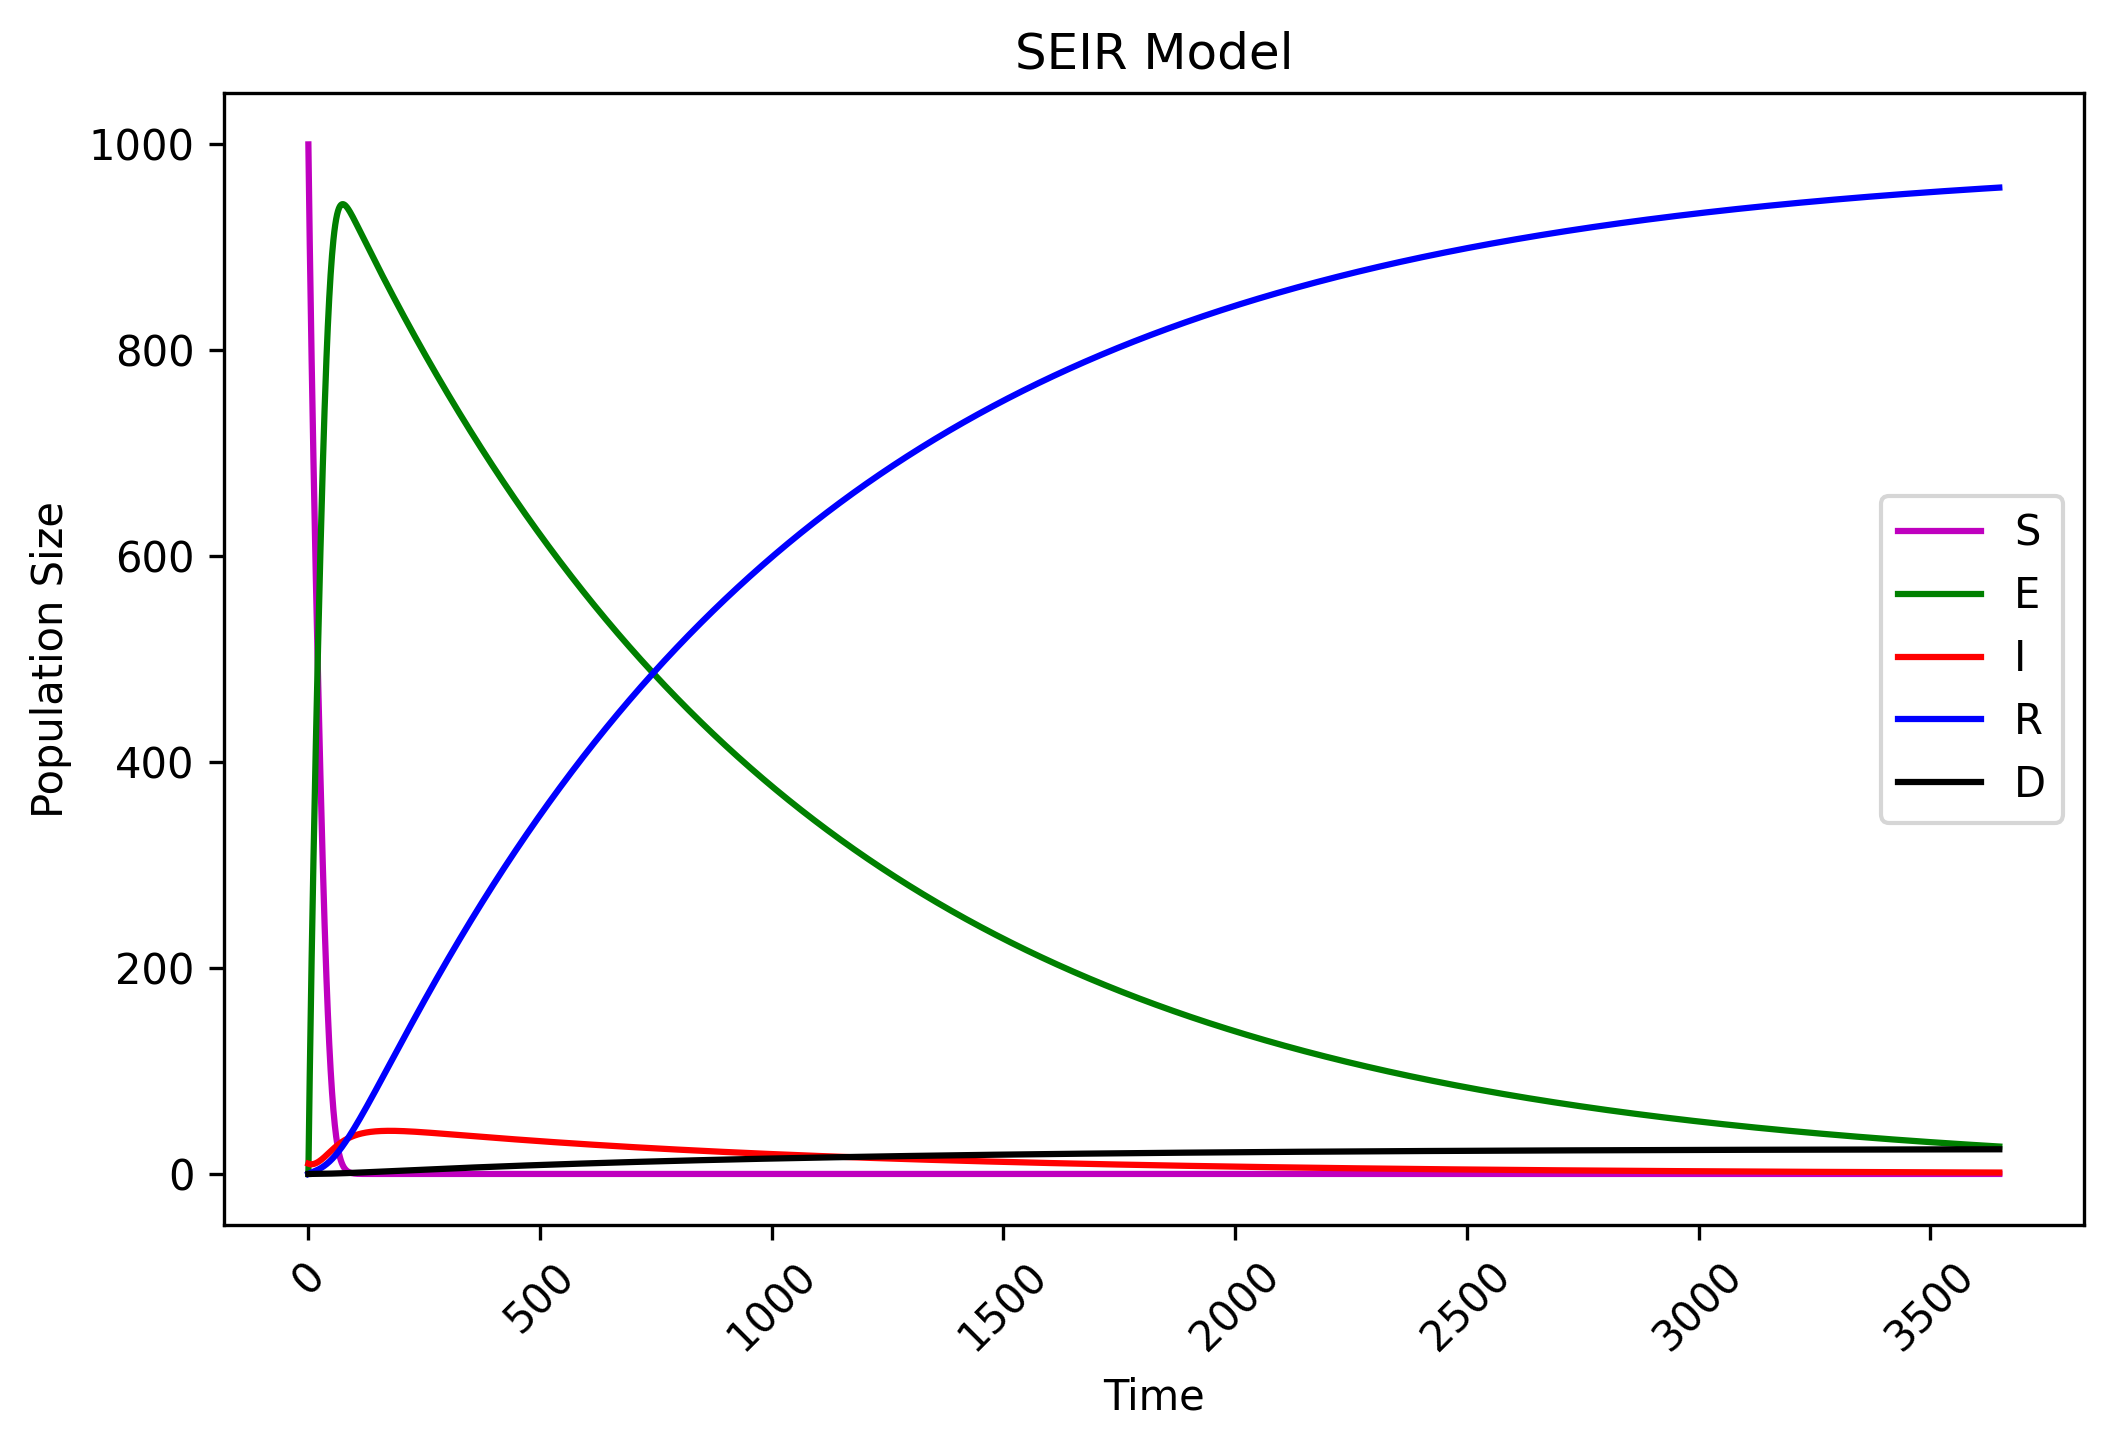

In [6]:
model.plot_timeseries()

## Fitting an epidemic model to infection data

The rate parameters for epidemic models can be estimated from a variety of empirical sources. One common way to estimate the exposure rate is to use data on infections. In our toy example, we will use our model system to simulate infection data with added noise. Then we can attempt to fit the model to these noisy data to recover our expected parameter value.

### Simulate noisy infection data

The `SEIR` class implements a deterministic disease transmission model. There are many ways to implement stochastic disease transmission models, but instead we will add Gaussian noise to the output of the deterministic model. This is reflective of noise in measurement of infections, rather that stochastic transmission.

`class SimulateEpidemic` inherits from the `SEIR` class (it has the same model structure and instance variables), but has an additional function to add noise to the outputs of the model

In [7]:
class SimulateEpidemic(SEIR):
    
    def __init__(self, noise, **kwds):
        self.noise = noise
        super().__init__(**kwds)
        
    def simulate_daily_noise(self, compartment_name):
        
        deterministic = self.integrate()
        n_samples = len(self.results[:, self.compt_map[compartment_name]])
        noise = np.random.normal(loc=0, scale=self.noise, size=self.days_sim)
        updated = self.results[::self.interval_per_day, self.compt_map[compartment_name]] + noise
        
        return updated


`SimulateEpidemic` is instantiated with the same epidemic parameters as its base class `SEIR`, and the additional parameter `noise`. `noise` is the standard deviation to use for a normal distribution with mean 0.

In [8]:
noisy_epidemic = SimulateEpidemic(noise=1, **pars)

In [9]:
inf_noise = noisy_epidemic.simulate_daily_noise(compartment_name='I')

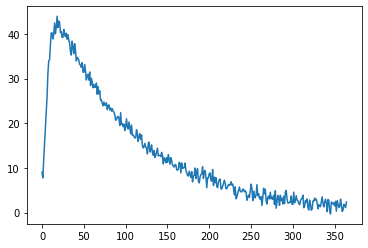

In [10]:
plt.plot(range(len(inf_noise)), inf_noise)

### Fit to noisy data

We will define another class, `FitEpidemic`, which also inherits from `SEIR`. `class FitEpidemic` takes additional parameters `data` (our simulated data), and `compt` (the name of the compartment to which we are fitting the model).

In our exmaple, we simulate noisy infection data, and then fit exposure rate to the "infectious" compartment.

We will also define two helper functions for calculating model error, `rmsd_t` and `nrmsd_t`. These functions calculate root mean square deviation and normalized root mean square deviation, respectively.

In [72]:
def rmsd_t(error):
    """Root mean squared deviation for time series"""

    return sum([i**2 for i in error])/len(error)


def nrmsd_t(rmsd, data):
    """Normalised root mean squared deviation"""

    return rmsd/(max(data) - min(data))

In [43]:
class FitEpidemic(SEIR):
    
    def __init__(self, data, compt, **kwds):
        self.data = data
        self.compt = compt
        super().__init__(**kwds)
        
    def fit_exposure(self, fit_guess=0.04, fit_var_names=['exposure_rate']):
        """Wrapper around scipy.optimize.least_squares"""

        # call scipy.optimize.least_squares
        soln_full = least_squares(
            fun=self.calc_residual,
            x0=fit_guess,
            x_scale=0.01,
            #xtol=1e-8,  # default
            bounds=[0, 100]
        )

        # convert fitted values to dictionary
        soln_lst = list(soln_full['x'])
        soln_dict = dict({
            name: val for name, val in zip(fit_var_names, soln_lst)
        })

        # get the final error
        soln_dict['final_error'] = soln_full['fun']

        # Calculate final rmsd and nrmsd
        soln_dict['final_rmsd'] = rmsd_t(soln_dict['final_error'])
        soln_dict['final_nrmsd_t'] = nrmsd_t(soln_dict['final_rmsd'], self.data)

        return soln_dict

    def calc_residual(self, fit_var):
        """Callback function for fit_to_data"""

        # update exposure rate
        self.exposure_rate = fit_var
        self.integrate()
        fit_compt = self.results[0:(len(self.data)*self.interval_per_day):self.interval_per_day, self.compt_map[self.compt]]
        residual = fit_compt - self.data

        return residual

Select a number of days of observation to use for fitting:

In [44]:
n_days_observations = 14
first_2wks = inf_noise[:n_days_observations]

In [46]:
fit_inf = FitEpidemic(first_2wks, 'I', **pars)

In [47]:
est = fit_inf.fit_exposure()

In [48]:
est

{'exposure_rate': 0.03524282931418235,
 'final_error': array([ 0.9714929 ,  1.80708545, -0.53339063, -0.79884988, -0.41402839,
         0.44414033,  0.9930714 , -0.66614721, -0.68666861,  1.40411042,
        -0.10189104, -1.41973089, -0.3604488 ,  1.7701479 ]),
 'final_rmsd': 1.0473607423127578,
 'final_nrmsd_t': 0.03226229692393642}

In [50]:
fit_inf.exposure_rate

array([0.03524284])

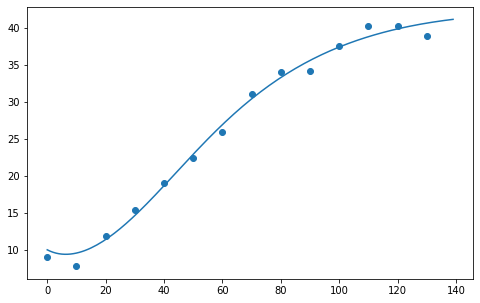

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(
    range(0, len(first_2wks)*fit_inf.interval_per_day),
    fit_inf.results[:,fit_inf.compt_map['I']][0:len(first_2wks)*fit_inf.interval_per_day]
)
ax.scatter(
    range(0, len(first_2wks)*fit_inf.interval_per_day, fit_inf.interval_per_day), 
    first_2wks
)

# Exercises

1. Try running the SEIR model with different parameters. What impact do they have on the dynamics of the epidemic?
2. Try increasing the noise in the data simulation. How does noise impact parameter estimates?
3. Try increasing and decreasing the number of time steps used for fitting. How many days of data do you need to get a good fit?